<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lab:-Random-Forests" data-toc-modified-id="Lab:-Random-Forests-1">Lab: Random Forests</a></span><ul class="toc-item"><li><span><a href="#Overview-of-Random-Forest" data-toc-modified-id="Overview-of-Random-Forest-1.1">Overview of Random Forest</a></span></li><li><span><a href="#Preview-of-this-Notebook" data-toc-modified-id="Preview-of-this-Notebook-1.2">Preview of this Notebook</a></span></li><li><span><a href="#1.-Import-packages" data-toc-modified-id="1.-Import-packages-1.3">1. Import packages</a></span></li><li><span><a href="#2.-Load-and-format-data" data-toc-modified-id="2.-Load-and-format-data-1.4">2. Load and format data</a></span></li><li><span><a href="#3.-Bagging" data-toc-modified-id="3.-Bagging-1.5">3. Bagging</a></span></li><li><span><a href="#4.-Build-a-Random-Forest" data-toc-modified-id="4.-Build-a-Random-Forest-1.6">4. Build a Random Forest</a></span></li><li><span><a href="#5.-Tune-Parameters" data-toc-modified-id="5.-Tune-Parameters-1.7">5. Tune Parameters</a></span></li><li><span><a href="#6.-Feature-Importance" data-toc-modified-id="6.-Feature-Importance-1.8">6. Feature Importance</a></span></li><li><span><a href="#Takeaways" data-toc-modified-id="Takeaways-1.9">Takeaways</a></span></li></ul></li></ul></div>

Lab: Random Forests
=====

<a href="https://drive.google.com/file/d/1g2AT3S5cgu5HjMYt4X-WiVs0RUvI6Z3s/view" target="_blank">
     <img src="http://www.deltanalytics.org/uploads/2/6/1/4/26140521/screen-shot-2019-01-05-at-4-51-10-pm_orig.png" width="500" height="400">
</a>

[Page 28](https://drive.google.com/file/d/1g2AT3S5cgu5HjMYt4X-WiVs0RUvI6Z3s/view)

Overview of Random Forest
----

- Random Forest is based on Decision Trees -> many trees = a forest!
- Grows multiple trees on random subsets of the parent dataset
- At every split, a new random subset of features is chosen
    - `Heuristic is applyed to know which is the best feature`
    - This leads to "decorrelated" trees which leads to a large increase in performance!
    
Following on from Lab 4.1: Decision trees, the Random Forest algorithm is based on Decisions Trees and can be used for either regression or classification tasks. To overcome Decisions Trees tendancy to overfit, Random Forests aggregate the results from many decision trees with an [ensemble approach](http://scikit-learn.org/stable/modules/ensemble.html). 

In this lesson we focus on Random Forests, which use bagging to prevent overfitting by only allowing a given decision tree to optimize for a random subset of the data for every tree, and a random subset of the input features at every split. (Don't worry if this does not make too much sense right now, we'll work through together  😀). 

Preview of this Notebook
------

1. Import packages
2. Load data
3. Bagging
4. Build a Random Forest
5. Tune parameters
6. Feature importance

A quick refresher on Bagging:
- Grow multiple decisions trees from random subsets of the data
- All features are considered at every split in the decision tree
- The result is the average prediction of all trees

A quick refresher on the Random Forest theory:
- Random Forest is based on Decision Trees -> many trees = a forest!
- Grows multiple trees on random subsets of the parent dataset
- **At every split, a new random subset of features is chosen**
- This leads to "decorrelated" trees which leads to a large increase in performance!

Again, we will be looking at how we can predict the loan amount using the random forest algorithm. 

Here is a very [simple example](https://bicorner.com/2015/10/26/random-forest-using-ipython/) of how the RandomForestClassifier works: 

## 1. Import packages
<a id='loaddata'></a>

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

## 2. Load and format data
<a id='loaddata'></a>

In [30]:
# Load data

try: 
    # Local version
    path = "../data/"
    filename = 'loans.csv'
    df = pd.read_csv(path+filename)
except FileNotFoundError or ParserError: 
    # If not local, get from remote repo. Helpful if using colab.
    url = 'https://raw.githubusercontent.com/DeltaAnalytics/machine_learning_for_good_data/master/loans.csv'
    df = pd.read_csv(url)

# It always a good to visually inspect the data
df.head()

,id_number,loan_amount,lender_count,status,funded_date,funded_amount,repayment_term,location_country_code,sector,description,use
0,736066,4825,60,funded,2014-08-03T17:51:50Z,4825,8,BJ,Retail,NaN,NaN
1,743090,975,34,funded,2014-08-18T09:10:54Z,975,12,BJ,Food,NaN,NaN
2,743120,950,25,funded,2014-08-09T17:46:35Z,950,14,BJ,Services,NaN,NaN
3,743121,825,28,funded,2014-08-24T17:00:38Z,825,14,BJ,Retail,NaN,NaN
4,743124,725,21,funded,2014-08-25T03:24:54Z,725,13,BJ,Retail,NaN,NaN


Here we choose a limited subset of data to conduct the analysis for the sake of training time. In practice, we should use more features. This is a mix of numberic and one hot-coded catergorical variables. 

In [5]:
# Drop everything that is not numeric
df = df.select_dtypes(exclude=['object'])

# With the following code we can see the changes after excluding object types and describe the data mean/std/min...
print(df.head())
df.describe()

   id_number  loan_amount  lender_count  funded_amount  repayment_term
0     736066         4825            60           4825               8
1     743090          975            34            975              12
2     743120          950            25            950              14
3     743121          825            28            825              14
4     743124          725            21            725              13


,id_number,loan_amount,lender_count,funded_amount,repayment_term
count,6.019000e+03,6019.000000,6019.000000,6019.000000,6019.000000
mean,1.359770e+06,1499.011464,35.661406,1325.070610,11.803290
std,3.719316e+05,2512.517280,73.420256,2444.726815,9.114948
min,1.377200e+04,50.000000,0.000000,0.000000,3.000000
25%,1.425188e+06,300.000000,7.000000,200.000000,8.000000
50%,1.550673e+06,625.000000,16.000000,525.000000,10.000000
75%,1.566204e+06,1825.000000,41.000000,1525.000000,14.000000
max,1.573593e+06,80000.000000,2665.000000,80000.000000,133.000000


In [6]:
y_column = 'loan_amount'
y = df[y_column]
# Drop returns a copy of the DataFrame with the specified columns removed  
X = df.drop([y_column, "id_number"], axis=1) # id_number will not be helpful

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Bagging
<a id='bagging'></a>

As Decision Trees naturally overfit to the data, better performance is achieved when an **ensemble approach** such as Bagging is used.

Bagging is a shorter term for Bootstrapping Aggregation which is a general procedure to reduce variance in models that have a tendancy to overfit.

This diagram below gives a visual overview of how bagging works in the context of a classifying algorithm.

<img src="./images/bagging.png" alt="bagging" style="width: 500px;height=500"/>

As an ensemble method, bagging does the following:
- Creates N random subsamples of the dataset using selection with replacement. (Statistically 1/3 of the data is left of each subsample)
- Trains a new decision tree on each N subsample
- Takes the prediction from each and every N tree and averages the result
- This average is the final output of the bagging model. 

This **Ensemble approach** uses the results of several random analyses to find an average response.

For each tree, there will be a sample of data which was not used to train the algorithm. This means that we can also measure the **out-of-bag** score ( or **oob_score**). This score evaluates the performance of the model on the sample not used while training an individual tree. (On average, a random ~1/3 of data are not used to train a given tree).


## 4. Build a Random Forest
<a id='randomforest'></a>

Even with Bagging, the decision trees can be largely correlated. This is because given subsets from the same dataset, the trees are probably going to split on the same features and result in very similar predictions.

To de-correlate the trees, we use a Random Forest Regressor, which at each split, only consider a random subsample of the features! This means that the trees are forced to make different split decisions and results in less correlated trees.

**A Random Forest is essentially bagged decision trees where each decision tree only considers a random subset of the features at each split**

In [8]:
# Check how many columns our dataset has...
print(f"Number of features =  {X_train.shape[1]}")
num_features = X_train.shape[1]

Number of features =  3


Recall the standard sklearn steps: 
- **Step 1: Initiate the algorithm** Define the parameters (& hyperparameters of the algorithm) of the algorithm. For example, the maximum depth, the minimum samples in a leaf etc. (Check documentation for more information)

- **Step 2: Train the algorithm** Train the algorithm by fitting it to the X_train and y_train datasets.

- **Step 3: Evaluating the algorithm** Evaluate the predictive power of the algorithm by comparing the predictive loan amount values to the true values. We can do this for the training and testing dataset.

We'll use the same function we created in the previous lab to combine these into a single step with the additional option of printing the oob_score, which we should use when available.

In [9]:
def train_score_regressor(sklearn_regressor, X_train, y_train, X_test, y_test, model_parameters, print_oob_score=False):
    """A helper function that:
        - Trains a regressor on training data
        - Scores data on training and test data
        - Returns a trained model
    """
    # Step 1: Initializing the sklearn regressor 
    regressor = sklearn_regressor(**model_parameters)
    
    # Step 2: Training the algorithm using the X_train dataset of features and y_train, the associated target features
    regressor.fit(X_train, y_train)
    
    # Step 3: Calculating the score of the predictive power on the training and testing dataset.
    training_score = regressor.score(X_train, y_train)
    testing_score = regressor.score(X_test, y_test)
    
    # Print the results!
    print(f"Train score: {training_score:>5.4f}")
    print(f"Test score: {testing_score:>7.4f}")
    if print_oob_score:
        print(f"OOB score: {regressor.oob_score_:>8.4f}")
        
    return regressor

Using the Random Forest algorithm instead of a single Decision tree introduces some new paramters that can be used to tune the model. Three new and important parameters are:
- n_estimaters = During the bagging, the number of subsamples to create and therefore the number of individual decision trees to train. 
- max_features = The maximum number of random features to consider at each split
- oob_score = whether or not to calculate the oob_score (described in bagging above)

To start we will randomly assign a value to these parameters and see how the model performs.

In [10]:
# define the parameters
parameters = {"oob_score": True, 
              "n_estimators": 50, 
              "max_features": num_features, 
              'random_state': 42}

trained_regressor = train_score_regressor(sklearn_regressor=RandomForestRegressor,
                                          X_train=X_train, 
                                          y_train=y_train, 
                                          X_test=X_test, 
                                          y_test=y_test, 
                                          model_parameters=parameters,
                                          print_oob_score=True)

Train score: 0.9700
Test score:  0.9212
OOB score:   0.8825


The R^2 of the OOB score above tell us the model is performing well on unseen data. This is confirmed by the comparable R^2 for the test data. 

In [11]:
# Plot a graph of the true values vs the predicted values for the training and test datasets
def plot_y_yhat_scatter(y_actual,y_predicted,train_test):
    ax = sns.regplot(x=y_actual, y=y_predicted, fit_reg=False)   
    ax.set_xlabel('true values')
    ax.set_ylabel('predicted values')
    ax.set_title('Relationship between true and predicted loan amounts: '+train_test+' results')
    pass

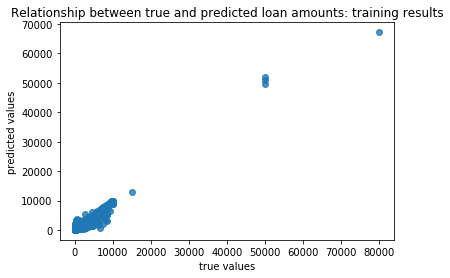

In [12]:
plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train),train_test="training")

#In this kind of graphics could be nice to add a reference line binding all the perfect predictions points

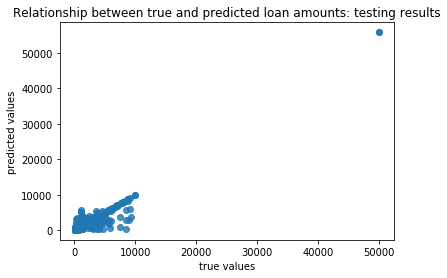

In [13]:
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test),train_test="testing")

## 5. Tune Parameters
<a id='parameters'></a>

Again, how do we know the best combination of hyperparameters? 

**Cross validated Grid Search!**

We're searching over a small range here to save time but in practice, we should search over a bigger range of hyperparameters. 

This can take a while 

In [14]:
# define parameters
parameters = {'max_depth':[7,10,15], 
#               'max_features': ['sqrt', 5, 10],
              'n_estimators': [50,100,200]}
# initialize model
rf_regressor= RandomForestRegressor(n_jobs=-1, random_state=42)
# initialize grid search and fit
regressor = GridSearchCV(rf_regressor, parameters)
regressor.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [15]:
# print out what GridSearchCV found to be the best parameters 
regressor.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 7,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [16]:
# Take the best parameters from grid search and fit a model
parameters = regressor.best_estimator_.get_params()
trained_regressor = train_score_regressor(sklearn_regressor=RandomForestRegressor,
                                          X_train=X_train, 
                                          y_train=y_train, 
                                          X_test=X_test, 
                                          y_test=y_test, 
                                          model_parameters=parameters,
                                          print_oob_score=False)

Train score: 0.9412
Test score:  0.9174


Compare this Random Forest to the result from the Decision Tree.

Which one is better?

Why?

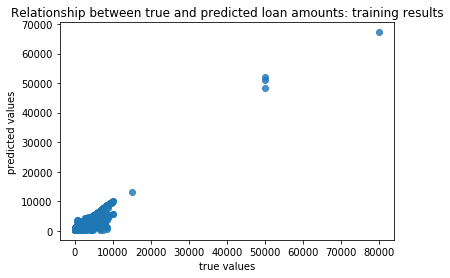

In [17]:
plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train),train_test="training")

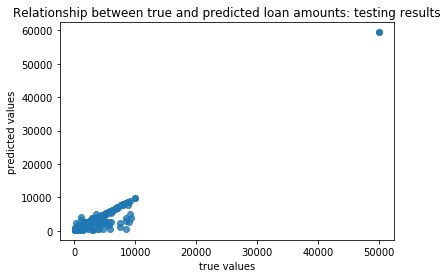

In [18]:
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test),train_test="testing")

## 6. Feature Importance
<a id='featureimportance'></a>
Remember the magnitude of the 'importance' is not indicative of how important the feature is, only the order matters!

For example,
- feature A has an importance of 0.5 
- feature B has an importance of 0.25. 

Then all we can take away is that feature A is more explains more variance then feautre B, **not** that feature A explains twice as much as feature B. 

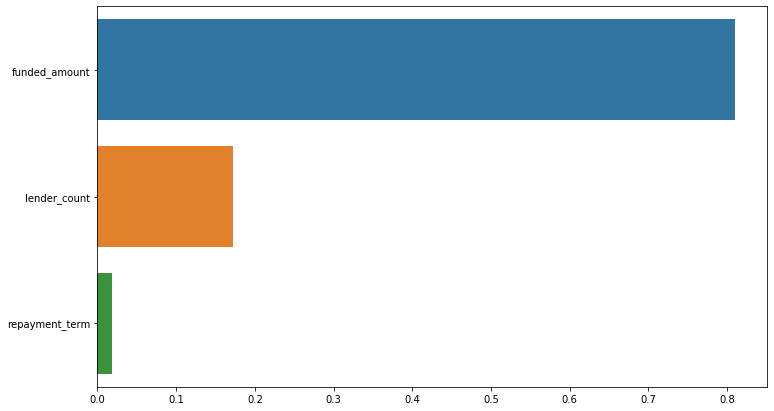

In [19]:
# Get the feature importances from our final trained model...
importances = trained_regressor.feature_importances_

# Find the indices of the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plotting a bar chart of feature importances in descending order
plt.figure(figsize=(12,7))
sns.barplot(y=X_train.columns[indices],
            x=importances[indices]);

Which feature is most important? Why?

Why are other features less important?

Takeaways
-----

- Random Forest are more useful than decision tree because \_\_\_\_\_\_\_\_\_.
- List the steps to fit a Random Forest in scikit-learn:
    1. 
    2.
    3.
    4.
    5.
- What ares the best ways to interpret a Random Forest?

<br>
<br> 
<br>

----